In [171]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# path = '/content/gdrive/MyDrive/Applied ML/'
path = './data/'
# save_path = 

In [172]:
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import files

# warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

np.random.seed(3333)

# from copy import deepcopy
# import multiprocessing as mp
# from multiprocessing.pool import Pool, ThreadPool
# from functools import partial
# import time
# from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import os
import pickle

# Class definition

In [173]:
class Mle:
  def __init__(self, data_path:str, sep:str=',', remove_head:bool=True,
              features_path:str=None, fsep:str=',', rem_fhead:bool=True,
              rebuild:bool=False) -> None:
              
    self.data_path     = data_path;       self.sep  = sep;    self.remove_head = remove_head
    self.features_path = features_path;   self.fsep = fsep;   self.rem_fhead   = rem_fhead
    self.rebuild = rebuild

    self.users_id = {};                   self.items_id = {}

    self.users_rating       = [];         self.items_rating       = []
    self.users_rating_train = [];         self.items_rating_train = []
    self.users_rating_test  = [];         self.items_rating_test  = []

    self.user_ratings_count        = [];   self.item_ratings_count        = []
    self.user_ratings_count_train  = [];   self.item_ratings_count_train  = []
    self.user_ratings_count_test   = [];   self.item_ratings_count_test   = []

    self.user_ratings_cum        = [];     self.item_ratings_cum       = []
    self.user_ratings_cum_train  = [];     self.item_ratings_cum_train = []
    self.user_ratings_cum_test   = [];     self.item_ratings_cum_test  = []

    self.users_freq_rating =     [];      self.items_freq_rating     = []
    self.users_uniq_rating_nbr = [];      self.items_uniq_rating_nbr = []

    self.number_of_users = self.number_of_items = 0

    self.mle_train = [];  self.rmse_train = [];   self.rmse_test = []
    self.mle = None;      self.rmse = {};         self.params = {}


    self.data_loader()
    self.get_freq()
    self.plots_path_builder()


# MAIN METHODS
  def get_data(self) -> None:
    with open(self.data_path, 'r') as data_file:
      data = data_file.readlines()
      uid = {};       iid = {}
      urat = [];      irat = []
      ucount = [];    icount = []

      a = b = 0
      i = j = 0
      rm = False
      k = 0
      for d in tqdm(data, desc="Data indexing"):
        if self.remove_head and not(rm):
          rm = not(rm)
          continue
        u = d.strip().split(self.sep)
        if u[0] not in uid:
          uid[u[0]] = a
          ucount += [0]
          a += 1
        i = sum(ucount[0:uid[u[0]]+1])
        ucount[uid[u[0]]] += 1

        if u[1] not in iid:
          iid[u[1]] = b
          icount += [0]
          b += 1
        j = sum(icount[0:iid[u[1]]+1])
        icount[iid[u[1]]] += 1
        
        urat.insert(i, (iid[u[1]], float(u[2])))
        irat.insert(j, (uid[u[0]], float(u[2])))

      nbr_user, nbr_item = len(ucount), len(icount)
      ucumcount = np.cumsum(ucount); mcumcount = np.cumsum(icount)

    if self.features_path:
      with open(self.features_path, 'r') as file:
        data = file.readlines()
        fid = {};     fitm = [];      ifea = []
        ficount = [];   ifcount = list(np.zeros((nbr_item,), dtype='int'))
        a = b = 0
        i = j = 0
        rm = False
        k = 0
        for d in tqdm(data, desc="Feature indexing"):
          if self.rem_fhead and not(rm):
            rm = not(rm)
            continue
          mf = d.strip().split(self.fsep)
          features = mf[2].strip().split('|')
          if mf[0] not in iid:
            continue
          j = sum(ifcount[0:iid[mf[0]]+1])
          ifcount[iid[mf[0]]] = len(features)
          for f in features:
            if f not in fid:
              fid[f] = a
              ficount += [0]
              a += 1
            i = sum(ficount[0:fid[f]+1])
            ficount[fid[f]] += 1

            fitm.insert(i, (iid[mf[0]]))
            ifea.insert(j, (fid[f]))
            j += 1

        self.users_id = uid;                self.items_id = iid
        self.users_rating = urat;           self.items_rating = irat
        self.number_of_users = nbr_user;    self.number_of_items = nbr_item
        self.user_ratings_count = np.array(ucount);    self.item_ratings_count = np.array(icount)
        self.user_ratings_cum = np.array(ucumcount);   self.item_ratings_cum = np.array(mcumcount)

        self.features_id = fid;             self.number_of_features = len(ficount)
        self.feature_items = fitm;          self.item_features = ifea
        self.feature_items_count = np.array(ficount);    self.item_features_count = np.array(ifcount)
        self.feature_items_cum = np.cumsum(ficount);     self.item_features_cum = np.cumsum(ifcount)


  def split_data(self, ratio=0.1):
    nbr_user = self.number_of_users; nbr_item = self.number_of_items
    mrtr = []; irtr = {}; items_rating_train = []
    mrts = []; irts = {}; items_rating_test  = []

    for m in tqdm(range(nbr_user), desc="Data spliting"):
      urat = self.get_user_items_and_ratings(m, self.users_rating, self.user_ratings_cum)
      ui = len(urat)
      uj = int(np.round(ui*ratio))
      uk = np.random.choice(ui, uj, replace=False)
      for i, (n,r) in enumerate(urat):
        if i in uk:
          mrts += [(n, r)]
          if n not in irts:
            irts[n] = [(m, r)]
          else:
            irts[n] += [(m, r)]
        else:
          mrtr += [(n, r)]
          if n not in irtr:
            irtr[n] = [(m, r)]
          else:
            irtr[n] += [(m, r)]
      self.user_ratings_count_train += [ui-uj];    self.user_ratings_count_test  += [uj]

    for n in range(nbr_item):
      if n in irtr:
        items_rating_train += irtr[n];    self.item_ratings_count_train += [len(irtr[n])]
      else:
        self.item_ratings_count_train += [0]

      if n in irts:
        items_rating_test  += irts[n];    self.item_ratings_count_test += [len(irts[n])]
      else:
        self.item_ratings_count_test += [0]

    self.users_rating_train = mrtr;   self.items_rating_train = items_rating_train
    self.users_rating_test  = mrts;   self.items_rating_test = items_rating_test
    self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
    self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
    self.user_ratings_cum_test = np.cumsum(self.user_ratings_count_test)
    self.item_ratings_cum_test = np.cumsum(self.item_ratings_count_test)


  def get_freq(self) -> None:
    u, m = np.array(self.user_ratings_count), np.array(self.item_ratings_count)
    ufreq = []; mfreq = []
    uuniq = []; muniq = []
    while True:
      if len(u) == 0 & len(m) == 0:
        break
      if len(u) > 0:
        ufreq += [len(u[u==u[0]])]
        uuniq += [u[0]]
        u = u[u!=u[0]]
      if len(m) > 0:
        mfreq += [len(m[m==m[0]])]
        muniq += [m[0]]
        m = m[m!=m[0]]

    self.users_freq_rating = ufreq;  self.items_freq_rating = mfreq
    self.users_uniq_rating_nbr = uuniq;  self.items_uniq_rating_nbr = muniq


  def mle_loss(self, lambd:float=0.05, gamma:float=0.1, tau:float=0.01, dim:int=2, epochs=50,
               with_users_items:bool=False, with_features:bool=False) -> None:

    with_features = with_features and (self.features_path is not None)
    # Initialisation
    self.params = {'lambda': lambd, 'gamma': gamma, 'tau': tau, 'dim': dim, 'epoch': 0}
    self.epochs = epochs
    cost = float('inf')
  
    std = np.sqrt(5 / np.sqrt(dim));    fstd = 1 / np.sqrt(dim)

    self.user_matrix    = np.random.normal(0,  std, size=(self.number_of_users, dim));
    self.item_matrix    = np.random.normal(0,  std, size=(self.number_of_items, dim));
    # self.feature_matrix = np.random.normal(0, fstd, size=(self.number_of_features, dim))\
    #   if with_features else None;
    self.feature_matrix = np.zeros((self.number_of_features, dim))\
      if with_features else None;


    self.user_biases = np.zeros(self.number_of_users);
    self.item_biases = np.zeros(self.number_of_items)

    self.mle_train = np.zeros(epochs); self.rmse_train = np.zeros(epochs)
    self.rmse_test = np.zeros(epochs)

    # Loss calculation
    for epoch in tqdm(range(epochs), desc="Data Training"):
      # Biases update
      ## User
      self.update_user_biases()
      ## Item
      self.update_item_biases()

      # with ThreadPoolExecutor(max_workers=20) as pool:
      #   pool.submit(self.update_user_biases, list(range(nbr_user)))
      #   pool.submit(self.update_item_biases, list(range(nbr_item)))
      # usumb2 = np.dot(ubiases, ubiases)
      # msumb2 = np.dot(mbiases, mbiases)

      # Update
      if with_users_items:
      ## User
        self.update_users()
      ## Item
        self.update_items(with_features)
      ## Features
        if with_features:
          self.update_features()

      # Loss
      ## Train data
      self.update_train_errors(epoch, with_users_items, with_features)
      ## Test data
      self.update_test_errors(epoch)

      # Save the best model and parameters
      if cost > self.rmse_test[epoch]:
        cost = self.rmse_test[epoch]
        self.params['epoch']: epoch
        self.mle = self.mle_train[epoch]
        self.rmse = {'train': self.rmse_train[epoch], 'test': cost}
        self.model_manager()
      
      # Print epoch loss amd cost
      if epoch == 0 or (epoch+1) % 5 == 0:
        print(f"epoch: {epoch+1}\t loss: {self.mle:.2f}\t train_cost: {self.rmse['train']}\t test_cost: {self.rmse['test']}")
  
  def model(self,user_index, item_index):
    self.model_manager(load=True)
    return np.dot(self.user_matrix[user_index], self.item_matrix[item_index]) \
          + self.user_biases[item_index] + self.item_biases[item_index]


# PLOT METHODS
  def plot_freq(self, save=False, fgsize=[6,6], ftsize=11, alpha=0.7,
                title = 'Power low', xlabel = 'count', ylabel = 'frequency',
                ulabel = 'user', mlabel = 'item',
                ucolor = '#0E88FF', mcolor = '#FF0000'):
    # Initialisation
    ux = self.users_uniq_rating_nbr
    mx = self.items_uniq_rating_nbr
    uy = self.users_freq_rating
    my = self.items_freq_rating

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xscale("log", base=10)
    ax.set_yscale("log", base=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(ux, uy, alpha=alpha, color=ucolor, label=ulabel)
    ax.scatter(mx, my, alpha=alpha, color=mcolor, label=mlabel)

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(title, pad=10)
    self.save_plot(plt, f'{self.plot_path}/power-low', save=save)
    

  def plot_loss(self, error='mle', save=False, fgname='mle', fgsize=[6,6], ftsize=11, alpha=1,
                title = 'Lost function', xlabel = 'Iteration', ylabel = 'mle value',
                lcolor = '#0E88FF', ecolor = '#FF0000') -> None:
    # Initialisation
    if self.mle_train is None:
      self.mle_loss()
    y_train = self.mle_train if error == 'mle' else self.rmse_train
    y_test  = []  if error == 'mle' else self.rmse_test
    x = np.array(range(1,self.epochs+1))

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.plot(x, y_train, alpha=alpha, color=lcolor, marker="+", label='Training set')
    if error == 'rmse':
      ax.plot(x, y_test, alpha=alpha, color=ecolor, marker="*", label='Testing set')
    ax.grid(alpha=0.5)
    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}", save=save)

  def item_embedding(self, feature_id, save=False, fgname='item-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Items embedding', xlabel = 'second component', ylabel = 'first component',
                color = '#0E88FF') -> None:
    # Initialisation
    items = self.get_feature_items(feature_id, self.feature_items, self.feature_items_cum)
    x = self.item_matrix[items,0];    y = self.item_matrix[items,1]
    f = self.feature_matrix[feature_id];

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color, marker='.')
    ax.scatter(f[0], f[1])

    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}", save=save)

  def feature_embedding(self, save=False, fgname='feature-embedding', fgsize=[8,8], ftsize=11, alpha=1,
                title = 'Features embedding', xlabel = 'second component', ylabel = 'first component',
                color = '#0E88FF') -> None:
    # Initialisation
    x = self.feature_matrix[:,0];    y = self.feature_matrix[:,1]

    fig, ax = plt.subplots(figsize=fgsize)

    # Annotate y-axis
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Plot
    ax.scatter(x, y, alpha=alpha, color=color)
    for fid in self.features_id:
      ax.annotate(fid, (x[self.features_id[fid]], y[self.features_id[fid]]))
    # Legend
    ax.legend(fontsize=ftsize)
    ax.set_title(f"{title} for dim = {self.params['dim']}", pad=10)
    self.save_plot(plt, f"{self.plot_path}/{fgname}-dim{self.params['dim']}-epochs{self.epochs}" , save=save)


# USEFUL METHODS
## SETTERS
  def update_user_biases(self):
    for m in range(self.number_of_users):
      b = 0
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        b = b + self.params['lambda'] * (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) + self.item_biases[n]))
      b = b / (self.params['lambda'] * len(ratings) + self.params['gamma'])
      self.user_biases[m] = b

  def update_item_biases(self):
    for n in range(self.number_of_items):
      b = 0
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      for m, r in ratings:
        b += self.params['lambda'] * (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) + self.user_biases[m]))
      b = b / (self.params['lambda'] * len(ratings) + self.params['gamma'])
      self.item_biases[n] = b

  def update_users(self):
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      A = np.zeros((self.params['dim'],self.params['dim']));   x = np.zeros(self.params['dim'])
      for n, r in ratings:
        A += self.params['lambda'] * np.outer(self.item_matrix[n],self.item_matrix[n])
        x += self.params['lambda'] * self.item_matrix[n] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.params['tau'] * np.eye(self.params['dim'])
      L = np.linalg.cholesky(A)
      self.user_matrix[m] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ x
  
  def update_items(self, with_features):
    for n in range(self.number_of_items):
      ratings = self.get_item_users_and_ratings(n, self.items_rating_train, self.item_ratings_cum_train)
      fn = self.get_item_features(n, self.item_features, self.item_features_cum) # Get item features
      A = np.zeros((self.params['dim'],self.params['dim']));   c = np.zeros(self.params['dim'])
      for m, r in ratings:
        A += self.params['lambda'] * np.outer(self.user_matrix[m], self.user_matrix[m])
        c += self.params['lambda'] * self.user_matrix[m] * (r - (self.user_biases[m] + self.item_biases[n]))
      A += self.params['tau'] * np.eye(self.params['dim'])
      c += (self.params['tau'] / np.sqrt(self.item_features_count[n])) * sum(self.feature_matrix[fn,:]) if with_features else 0
      L = np.linalg.cholesky(A)
      self.item_matrix[n] = np.linalg.inv(L.T) @ np.linalg.inv(L) @ c

  def update_features(self):
    for k in range(self.number_of_features):
      items = self.get_feature_items(k, self.feature_items, self.feature_items_cum)
      sum_fn = 0; sum_vn = 0
      for n in items:
        fn = self.get_item_features(n, self.item_features, self.item_features_cum)
        sum_fn += 1 / self.item_features_count[n]
        sum_vn += (self.item_matrix[n] * np.sqrt(self.item_features_count[n]) \
          - (sum(self.feature_matrix[fn,:]) - self.feature_matrix[k])) \
            / self.item_features_count[n]
      self.feature_matrix[k] = sum_vn / (1 + sum_fn)

  def update_train_errors(self, epoch, with_users_items, with_features):
    mle1 = 0
    fn = lambda n: self.get_item_features(n, self.item_features, self.item_features_cum)
    if with_users_items:
      if with_features:
        # self.update_features()
        fsumpred2 = np.sum([f @ f.T for f in self.feature_matrix])  # Feature squred
        sum_fn = lambda n: sum(self.feature_matrix[fn(n),:]) / np.sqrt(self.item_features_count[n])
        msumpred2 = np.sum([(v - sum_fn(n)) @ (v - sum_fn(n)).T for n,v in enumerate(self.item_matrix)])
      else:
        msumpred2 = np.sum([v @ v.T for v in self.item_matrix])  #  # Item squared without features
      usumpred2 = np.sum([u @ u.T for u in self.user_matrix])    #  # User squared
    usumb2 = np.dot(self.user_biases, self.user_biases)
    msumb2 = np.dot(self.item_biases, self.item_biases)

    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_train, self.user_ratings_cum_train)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    mle_train = self.params['lambda']*mle1 + self.params['gamma']*(usumb2+msumb2)
    mle_train += self.params['tau']*(usumpred2+msumpred2) if with_users_items else 0
    mle_train += self.params['tau']*fsumpred2 if with_features else 0
    self.mle_train[epoch] = mle_train / 2
    self.rmse_train[epoch] = np.sqrt(mle1 / self.user_ratings_cum_train[-1])

  def update_test_errors(self, epoch):
    mle1 = 0
    for m in range(self.number_of_users):
      ratings = self.get_user_items_and_ratings(m, self.users_rating_test, self.user_ratings_cum_test)
      for n, r in ratings:
        mle1 = mle1 + (r - (np.dot(self.user_matrix[m], self.item_matrix[n]) \
          + self.user_biases[m] + self.item_biases[n]))**2
    self.rmse_test[epoch] = np.sqrt(mle1 / self.user_ratings_cum_test[-1])


## GETTERS
  def get_user_items_and_ratings(self, user_index, data=None, cum=None):
    if data is None:
      data = self.users_rating
      cum = self.user_ratings_cum
    a = 0 if user_index == 0 else cum[user_index-1]
    b = cum[user_index]
    return data[a:b]

  def get_item_users_and_ratings(self, item_index, data=None, cum=None):
    if data is None:
      data = self.items_rating
      cum  = self.item_ratings_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_item_features(self, item_index, data=None, cum=None):
    if data is None:
      data = self.item_features
      cum  = self.item_features_cum
    a = 0 if item_index == 0 else cum[item_index-1]
    b = cum[item_index]
    return data[a:b]

  def get_feature_items(self, feature_index, data=None, cum=None):
    if data is None:
      data = self.feature_items
      cum = self.feature_items_cum
    a = 0 if feature_index == 0 else cum[feature_index-1]
    b = cum[feature_index]
    return data[a:b]


# OTHERS
  def save_plot(self, fig_plt, name, ext='.pdf', save=True):
    if save:
      filenane = f"{name}{ext}"
      fig_plt.savefig(filenane)
    else:
      fig_plt.show()

  def plots_path_builder(self):
    n = self.user_ratings_cum[-1]
    d = 1;          p = ''
    if n >= 10**3 and n < 10**6:
      d = 10**3;    p = 'k'
    else:
      d = 10**6;    p = 'm'
    path = f'./plots/ml-{np.floor(n/d):.0f}{p}'

    try: 
      os.makedirs(path, exist_ok = True)
      self.plot_path = path
      # print("Directory '%s' created successfully" % path)
    except OSError as error: 
      print("Directory '%s' can not be created" % path)

  def data_loader(self):
    err = False
    filename = "data.pkl"
    try:
      if self.rebuild:
        pass
      else:
        with open(filename, 'rb') as file:
          data = pickle.load(file)
          # print(data)
          self.users_id           = data['uid'];            self.items_id           = data['iid']
          self.users_rating       = data['urat'];           self.items_rating       = data['irat']
          self.user_ratings_count = data['ucount'];         self.item_ratings_count = data['icount']

          self.features_id          = data['fid']
          self.feature_items        = data['fitm'];         self.item_features       = data['ifea']
          self.feature_items_count  = data['ficount'];      self.item_features_count = data['ifcount']
          
          self.users_rating_train       = data['uratr'];    self.items_rating_train       = data['iratr']
          self.users_rating_test        = data['urats'];    self.items_rating_test        = data['irats']
          self.user_ratings_count_train = data['ucountr'];  self.item_ratings_count_train = data['icountr']
          self.user_ratings_count_test  = data['ucounts'];  self.item_ratings_count_test  = data['icounts']


          self.number_of_users    = len(self.user_ratings_count)
          self.number_of_items    = len(self.item_ratings_count)
          self.number_of_features = len(self.feature_items_count)

          self.user_ratings_cum   = np.cumsum(self.user_ratings_count)
          self.item_ratings_cum   = np.cumsum(self.item_ratings_count)
          self.feature_items_cum  = np.cumsum(self.feature_items_count)
          self.item_features_cum  = np.cumsum(self.item_features_count)

          self.user_ratings_cum_train = np.cumsum(self.user_ratings_count_train)
          self.item_ratings_cum_train = np.cumsum(self.item_ratings_count_train)
          self.user_ratings_cum_test  = np.cumsum(self.user_ratings_count_test)
          self.item_ratings_cum_test  = np.cumsum(self.item_ratings_count_test)

    except (OSError, IOError) as e:
      print('Data loading error\n', e)
      err = True
      
    if self.rebuild or err:
      self.get_data()
      self.split_data()

      data = {
        'uid':      self.users_id,                  'iid':      self.items_id,
        'urat':     self.users_rating,              'irat':     self.items_rating,
        'ucount':   self.user_ratings_count,        'icount':   self.item_ratings_count,

        'fid':      self.features_id,
        'fitm':     self.feature_items,             'ifea':     self.item_features,
        'ficount':  self.feature_items_count,       'ifcount':  self.item_features_count,

        'uratr':    self.users_rating_train,        'iratr':    self.items_rating_train,
        'urats':    self.users_rating_test,         'irats':    self.items_rating_test,
        'ucountr':  self.user_ratings_count_train,  'icountr':  self.item_ratings_count_train,
        'ucounts':  self.user_ratings_count_test,   'icounts':  self.item_ratings_count_test
      }
      # print(data['uid'])
      
      with open(filename, 'wb') as file:
        pickle.dump(data, file)
        
      self.rebuild = False
    
  def model_manager(self, load=False):
    filename = "model.pkl"
    try:
      if load:
        with open(filename, 'rb') as file:
          data = pickle.load(file)
          self.user_matrix = data['upred'];       self.item_matrix = data['ipred']
          self.feature_matrix = data['fpred']
          self.user_biases = data['ubiases'];     self.item_biases = data['ibiases']
          self.mle = data['mle'];                 self.rmse = data['rmse']
          self.params = data['params']
      else:
        data = {
          'upred':    self.user_matrix,           'ipred':    self.item_matrix,
          'fpred':    self.feature_matrix,
          'ubiases':  self.user_biases,           'ibiases':  self.item_biases,
          'mle':      self.mle,                   'rmse':     self.rmse,
          'params':   self.params
        }
      
        with open(filename, 'wb') as file:
          pickle.dump(data, file)

    except (OSError, IOError) as e:
      print('Model loading error\n', e)
      

Test

In [174]:
test = Mle(path + 'ratings.dat', features_path=path + 'movies.dat', sep='::', fsep='::', remove_head=False, rem_fhead=False, rebuild=False)
# test = Mle('./ml-100k/u.data', sep='\t', features_path=path + 'movies.csv', remove_head=False)
# test = Mle("./ml-25m/ratings.csv", sep=',', remove_head=True)

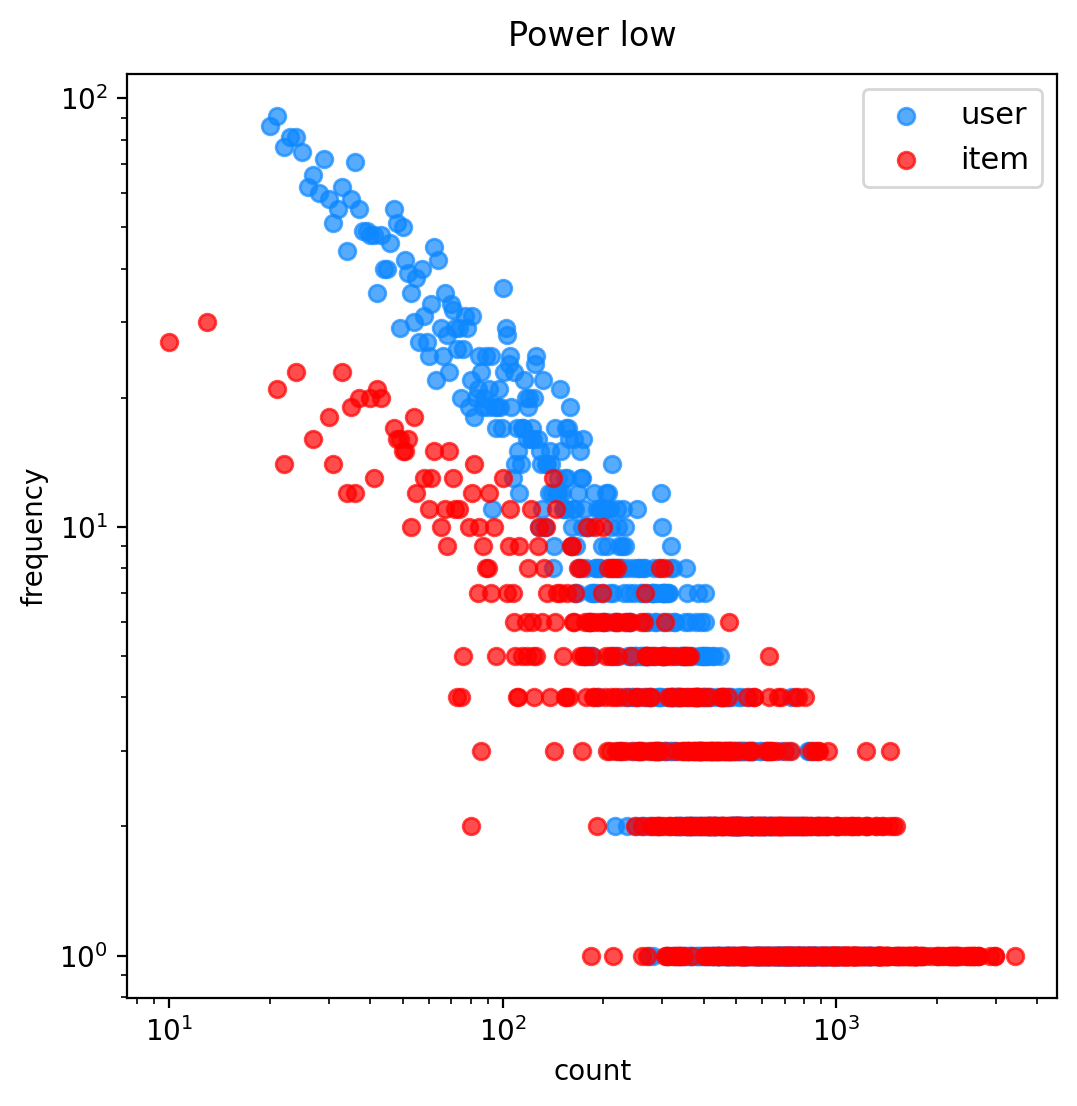

In [175]:
test.plot_freq(save=True)

In [176]:
test.mle_loss(epochs=20, dim=2, with_users_items=False, with_features=False)

Data Training:   5%|▌         | 1/20 [00:02<00:42,  2.22s/it]

epoch: 1	 loss: 609342.25	 train_cost: 5.1852009026939365	 test_cost: 5.24192593370519


Data Training:  25%|██▌       | 5/20 [00:11<00:33,  2.20s/it]

epoch: 5	 loss: 608063.20	 train_cost: 5.182060229571387	 test_cost: 5.238722985881387


Data Training:  50%|█████     | 10/20 [00:22<00:22,  2.21s/it]

epoch: 10	 loss: 607655.04	 train_cost: 5.182027914792068	 test_cost: 5.238689224486244


Data Training:  75%|███████▌  | 15/20 [00:33<00:11,  2.21s/it]

epoch: 15	 loss: 607323.07	 train_cost: 5.1820032537746314	 test_cost: 5.238663707764194


Data Training: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it]

epoch: 20	 loss: 607053.07	 train_cost: 5.18198498972841	 test_cost: 5.238645571382944


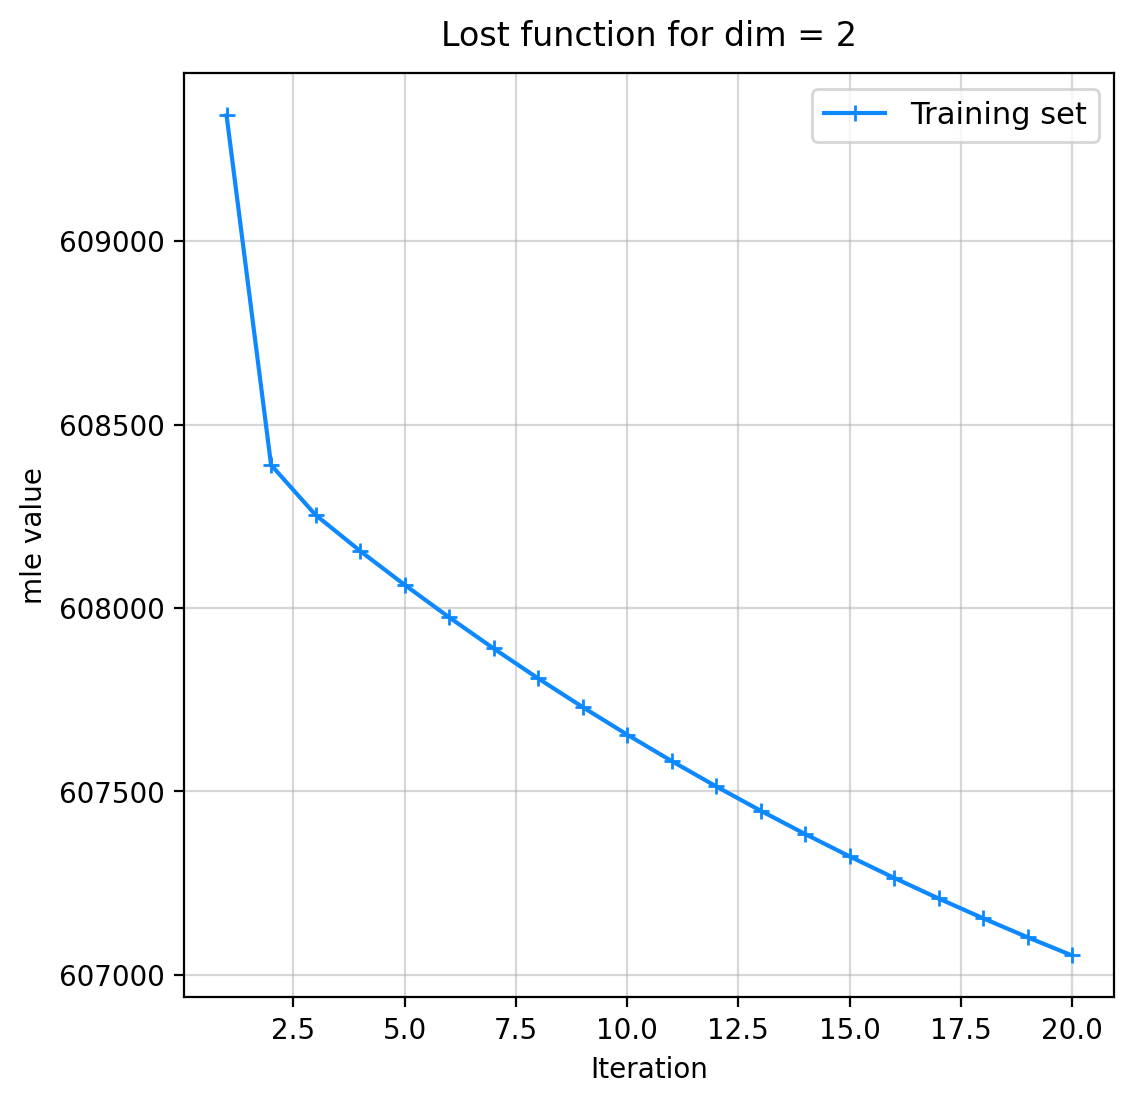

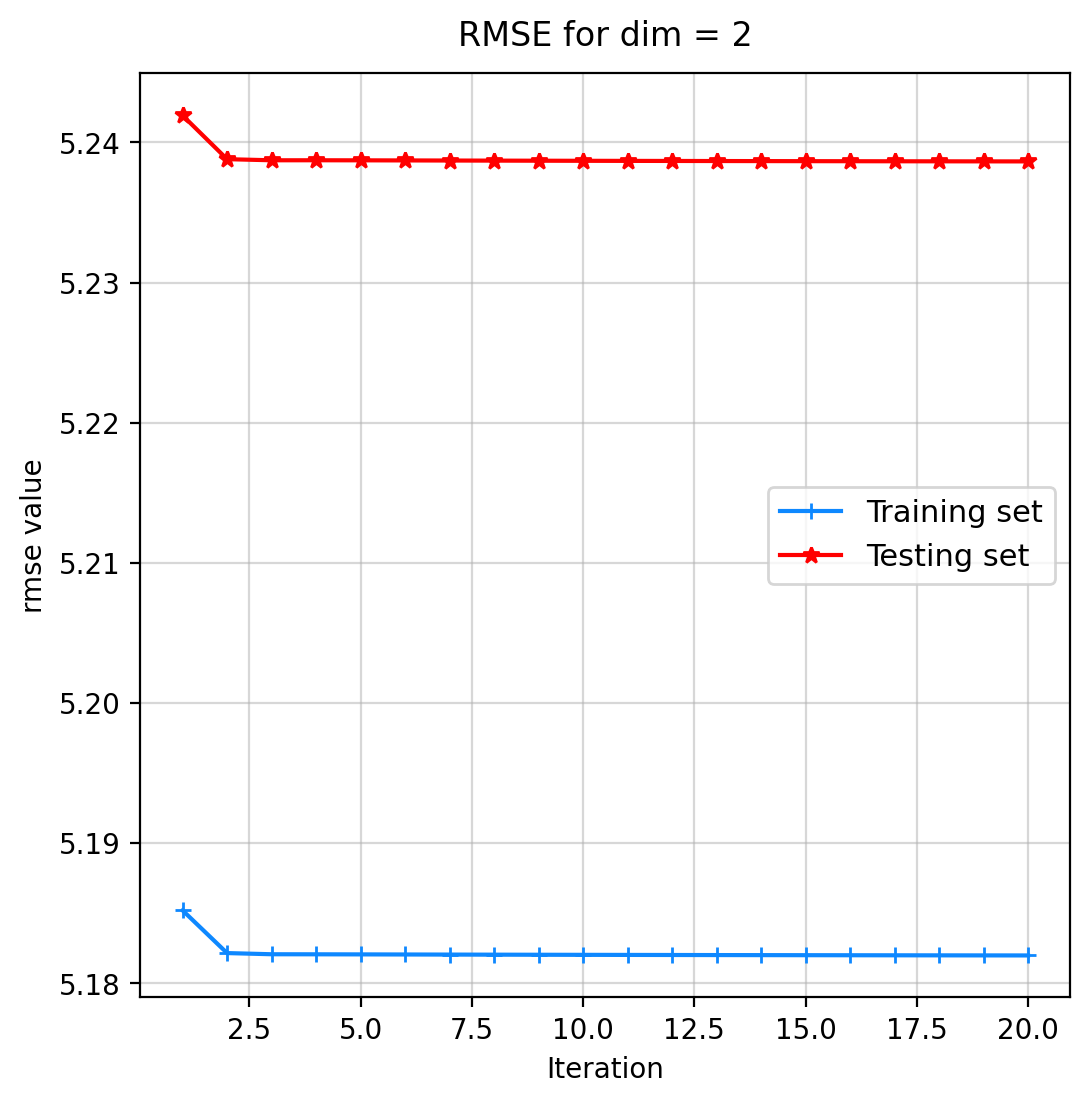

In [177]:
test.plot_loss(save=True)
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value', save=True)

In [178]:
m = 4
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.0, '8.9'),
 (4.0, '13.0'),
 (5.0, '2.1'),
 (4.0, '-0.3'),
 (4.0, '5.8'),
 (5.0, '3.9'),
 (2.0, '4.6'),
 (5.0, '0.8'),
 (3.0, '2.9'),
 (4.0, '5.4'),
 (2.0, '12.5'),
 (2.0, '4.5'),
 (1.0, '10.5'),
 (4.0, '4.0'),
 (3.0, '-4.1'),
 (3.0, '14.8'),
 (4.0, '8.4'),
 (2.0, '-8.9'),
 (2.0, '4.3'),
 (5.0, '10.4')]

In [179]:
test.mle_loss(epochs=20, dim=2, with_users_items=True, with_features=False)

Data Training:   5%|▌         | 1/20 [00:08<02:45,  8.71s/it]

epoch: 1	 loss: 27509.20	 train_cost: 1.0113948089797373	 test_cost: 1.050880934245885


Data Training:  25%|██▌       | 5/20 [00:43<02:09,  8.62s/it]

epoch: 5	 loss: 19867.92	 train_cost: 0.8533647856635662	 test_cost: 0.8816018640775533


Data Training:  50%|█████     | 10/20 [01:26<01:26,  8.61s/it]

epoch: 10	 loss: 19118.57	 train_cost: 0.8478106450410405	 test_cost: 0.8777865838171344


Data Training:  75%|███████▌  | 15/20 [02:09<00:43,  8.60s/it]

epoch: 15	 loss: 18695.65	 train_cost: 0.8465571709300528	 test_cost: 0.877573800221876


Data Training: 100%|██████████| 20/20 [02:51<00:00,  8.59s/it]

epoch: 20	 loss: 18363.74	 train_cost: 0.8456747452430354	 test_cost: 0.877272092365962


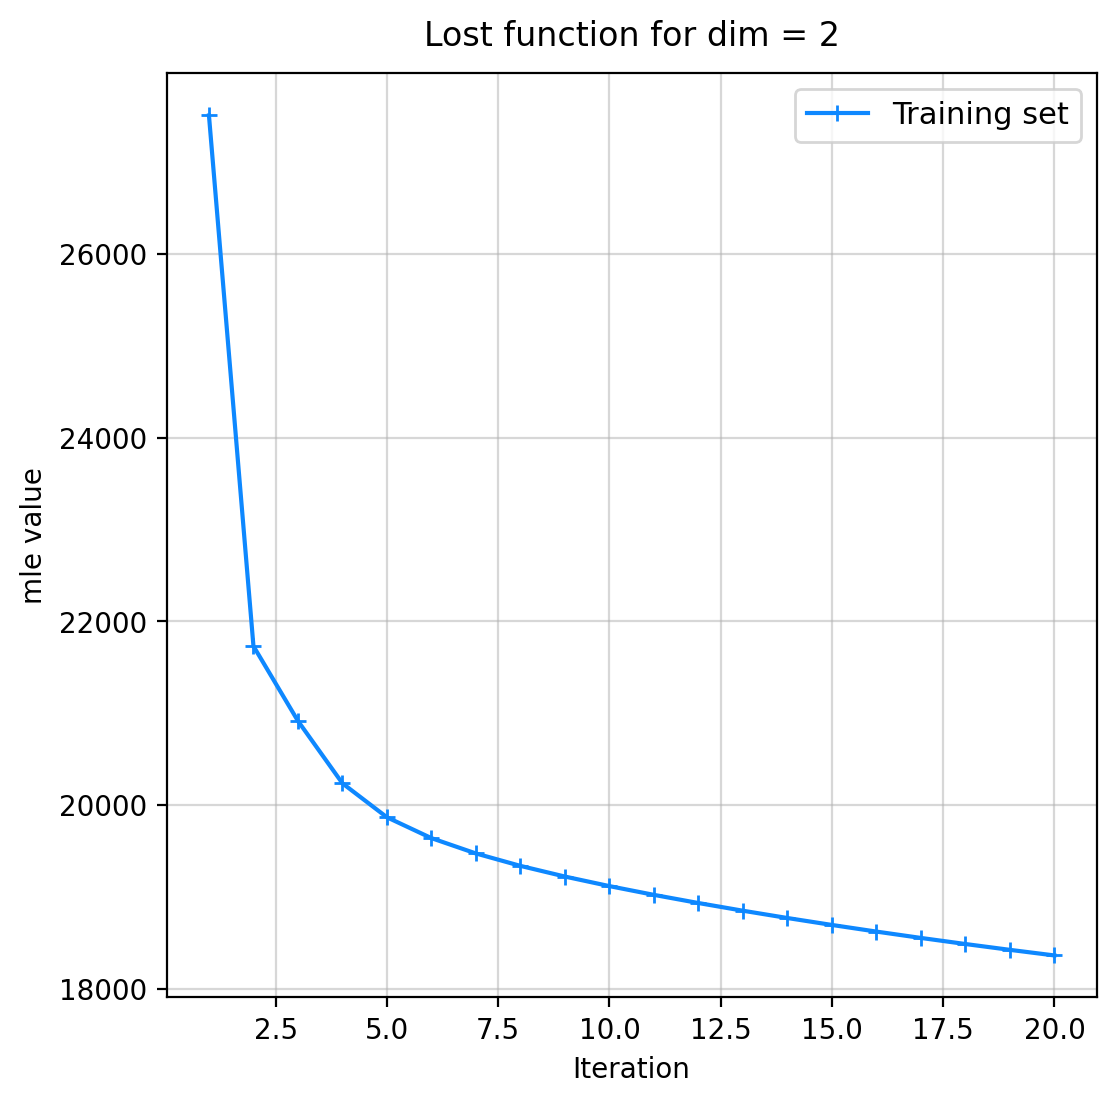

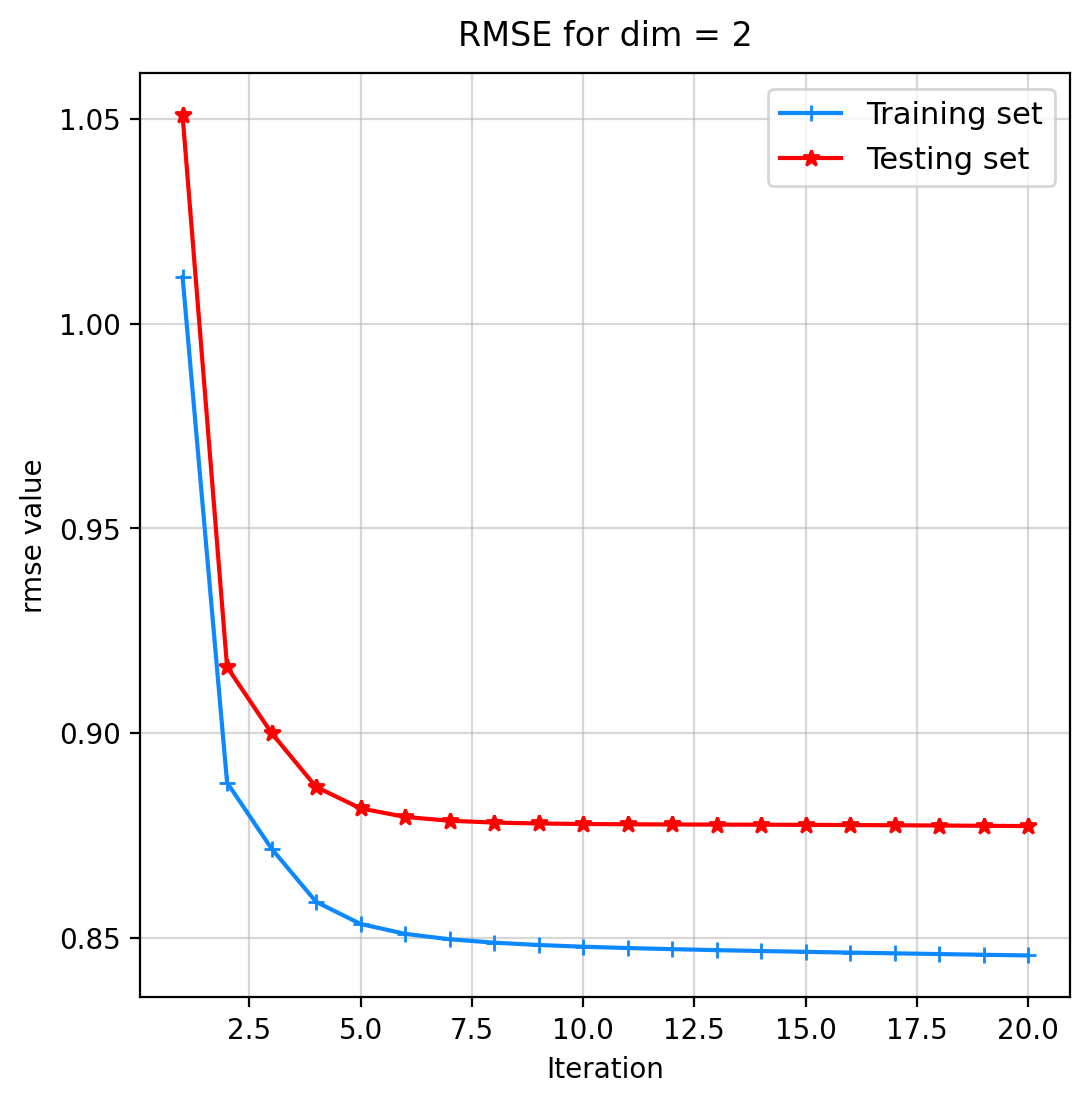

In [180]:
test.plot_loss()
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')
# test.item_embedding()
# test.feature_embedding()

In [181]:
m = 4
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.0, '2.9'),
 (4.0, '3.8'),
 (5.0, '3.5'),
 (4.0, '2.7'),
 (4.0, '3.0'),
 (5.0, '4.0'),
 (2.0, '3.3'),
 (5.0, '3.7'),
 (3.0, '3.7'),
 (4.0, '1.7'),
 (2.0, '4.8'),
 (2.0, '2.8'),
 (1.0, '1.9'),
 (4.0, '3.4'),
 (3.0, '1.6'),
 (3.0, '2.4'),
 (4.0, '3.6'),
 (2.0, '1.7'),
 (2.0, '2.1'),
 (5.0, '3.3')]

In [182]:
test.mle_loss(epochs=20, dim=2, with_users_items=True, with_features=True)

Data Training:   5%|▌         | 1/20 [00:08<02:46,  8.77s/it]

epoch: 1	 loss: 27524.68	 train_cost: 1.0122386044277523	 test_cost: 1.050242811893459


Data Training:  25%|██▌       | 5/20 [00:43<02:10,  8.73s/it]

epoch: 5	 loss: 19695.24	 train_cost: 0.8511542861673029	 test_cost: 0.8796801491494836


Data Training:  50%|█████     | 10/20 [01:26<01:26,  8.68s/it]

epoch: 10	 loss: 18879.72	 train_cost: 0.842849097248846	 test_cost: 0.8727118442314592


Data Training:  75%|███████▌  | 15/20 [02:10<00:43,  8.66s/it]

epoch: 15	 loss: 18500.40	 train_cost: 0.8417825433163321	 test_cost: 0.8724651505363117


Data Training: 100%|██████████| 20/20 [02:53<00:00,  8.68s/it]

epoch: 20	 loss: 18500.40	 train_cost: 0.8417825433163321	 test_cost: 0.8724651505363117


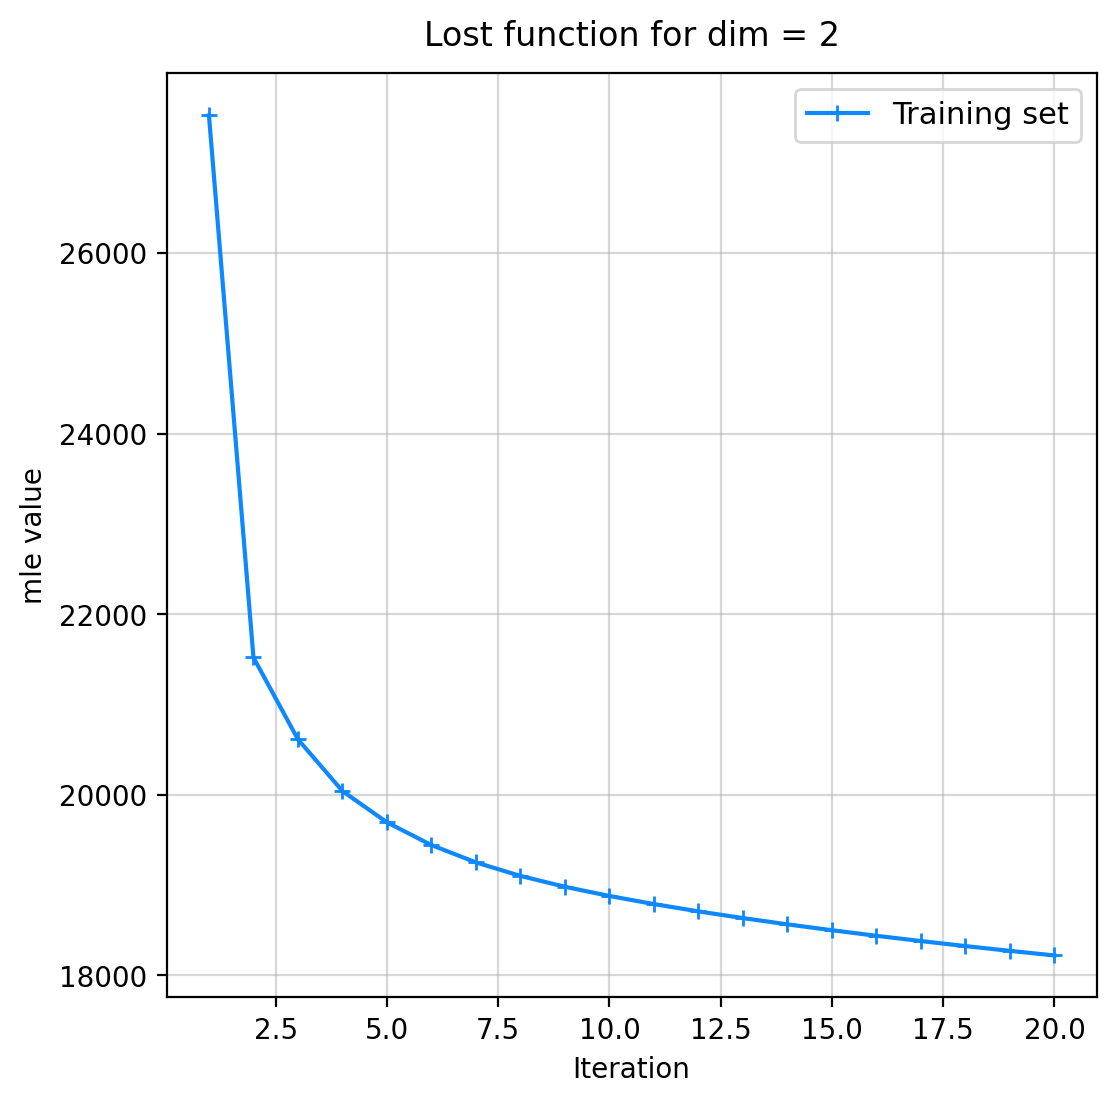

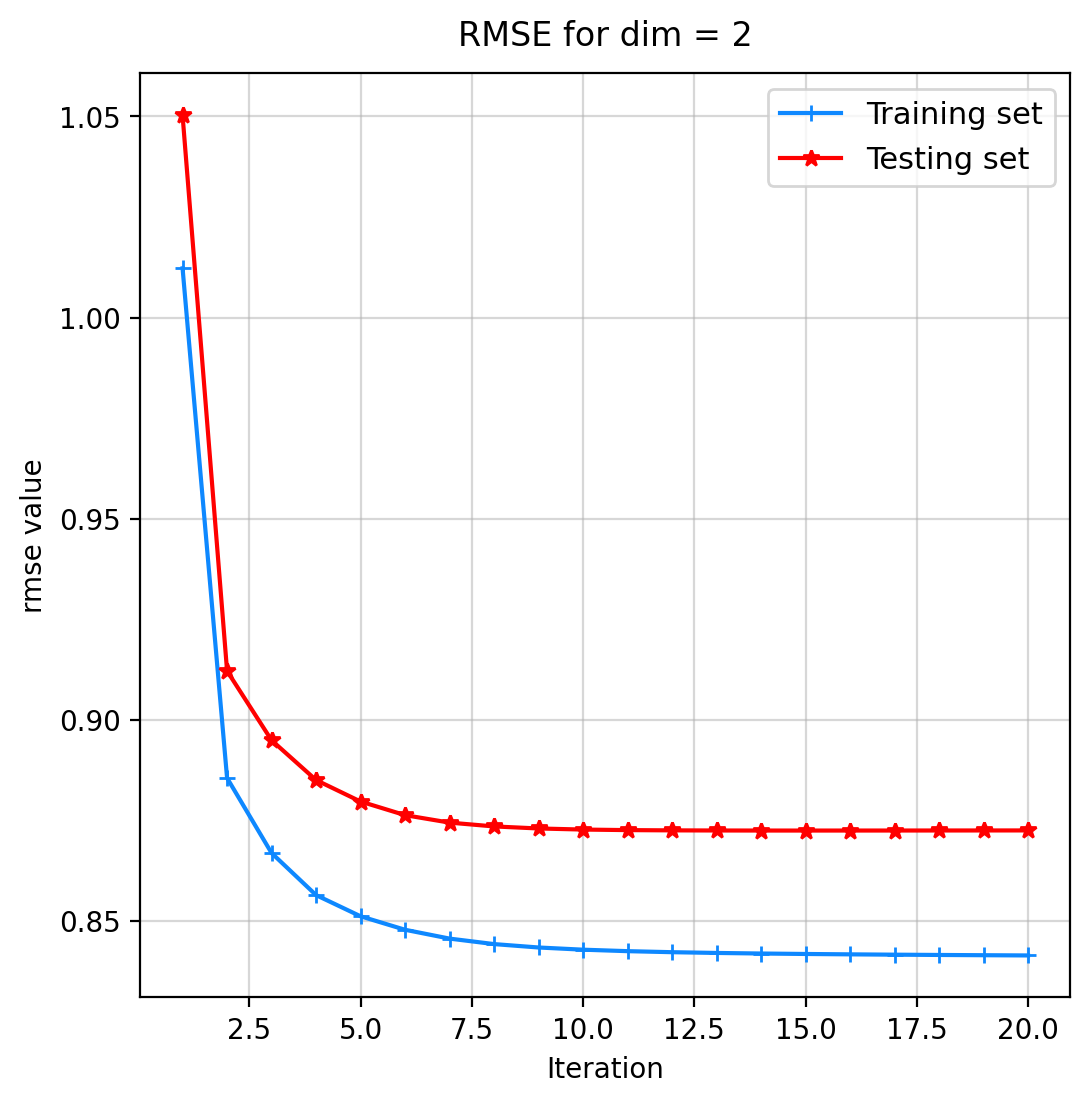

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


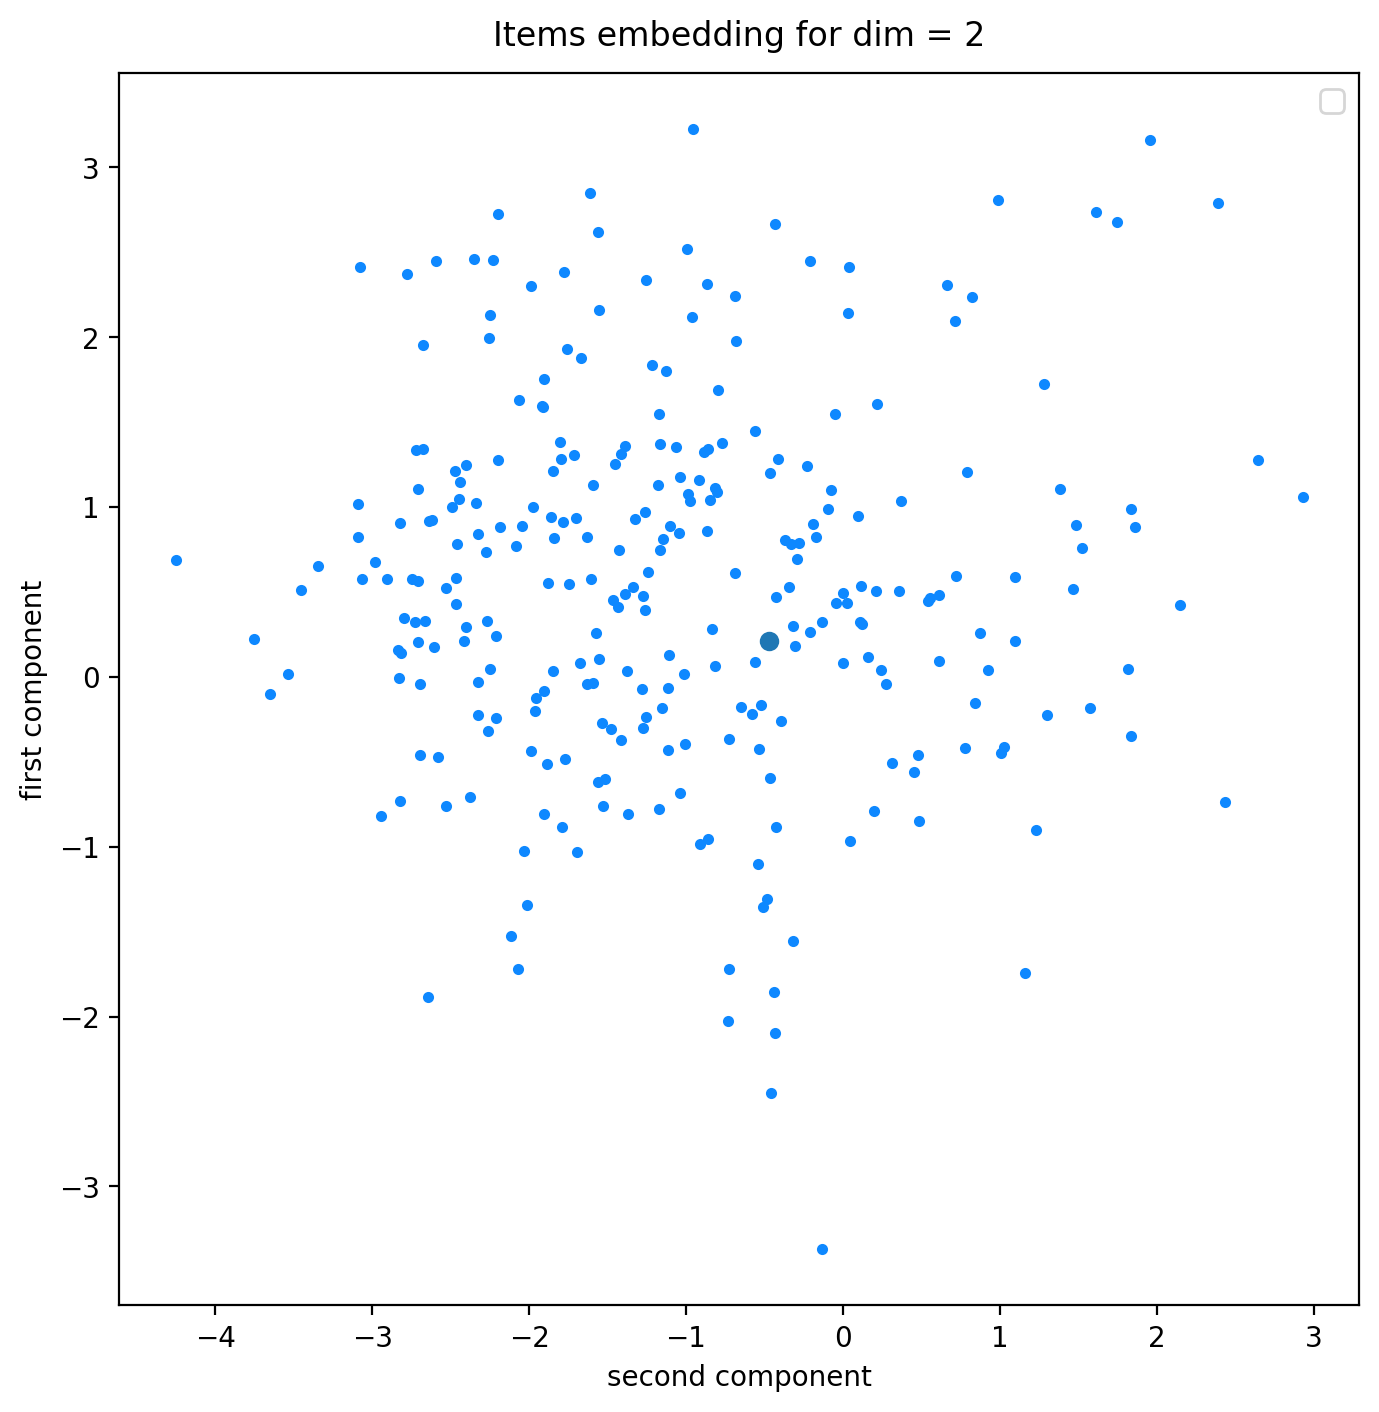

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


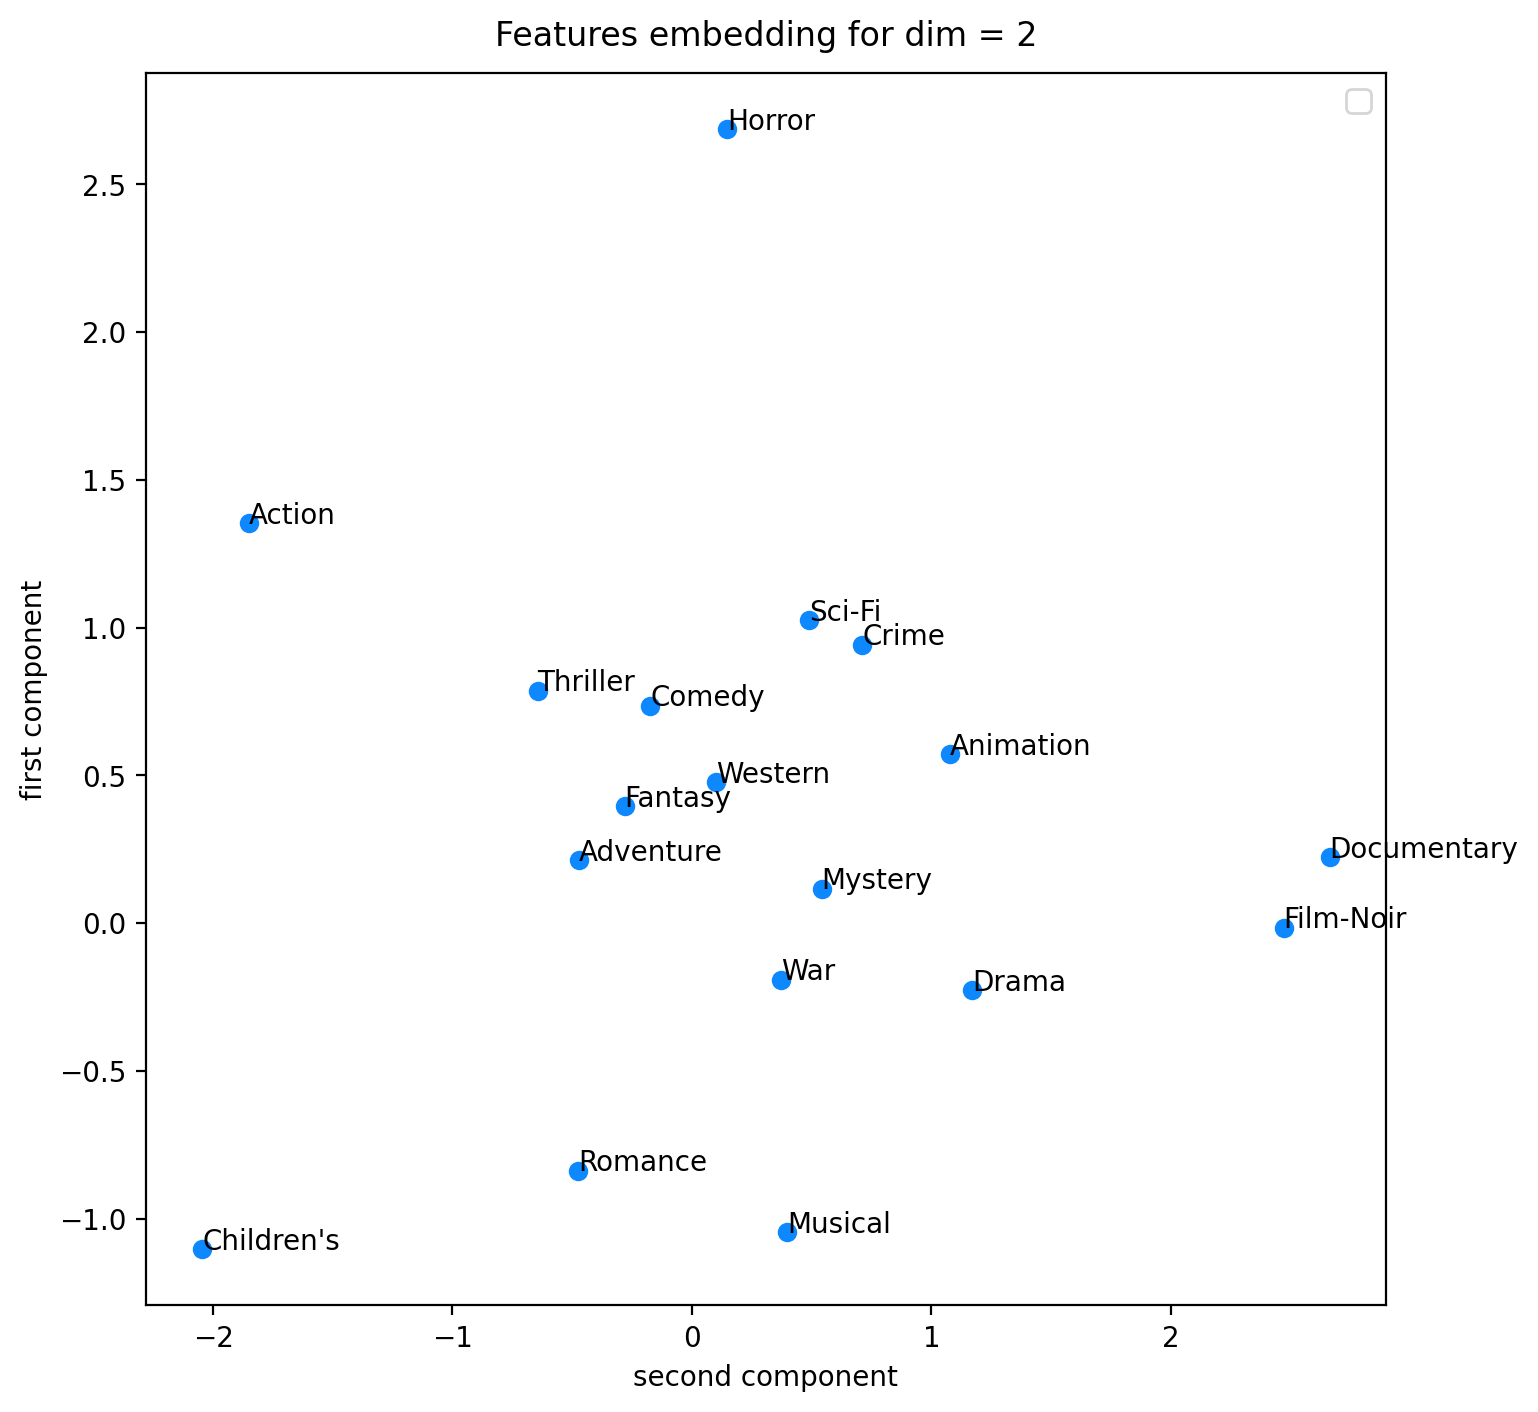

In [183]:
test.plot_loss()
test.plot_loss(error='rmse', fgname='rmse', title='RMSE', ylabel='rmse value')
test.item_embedding(3)
test.feature_embedding()

In [184]:
m = 4
# test.get_user_items_and_ratings(0, test.users_rating_train, test.user_ratings_cum_train)
im = test.get_user_items_and_ratings(m, test.users_rating_test, test.user_ratings_cum_test)
# test.user_ratings_cum_train
[(r, f"{test.model(m,n):.1f}") for n,r in im]

[(4.0, '3.4'),
 (4.0, '4.7'),
 (5.0, '4.3'),
 (4.0, '3.1'),
 (4.0, '3.8'),
 (5.0, '4.8'),
 (2.0, '3.3'),
 (5.0, '4.3'),
 (3.0, '4.5'),
 (4.0, '2.4'),
 (2.0, '4.8'),
 (2.0, '3.8'),
 (1.0, '2.1'),
 (4.0, '4.2'),
 (3.0, '3.2'),
 (3.0, '2.2'),
 (4.0, '4.2'),
 (2.0, '2.1'),
 (2.0, '2.8'),
 (5.0, '4.1')]

# Best parameters finding

In [185]:
# la = np.arange(.01,.1,.02);   ga = np.arange(.1,1,.2);    ta = np.arange(.005,0.016,.002)
# params = {}
# cost = float('inf')
# for l in la:
#   for g in ga:
#     for t in ta:
#       print(f"lambda = {l}\t gamma = {g}\t tau = {t}")
#       test = Mle(path + 'ratings.dat', features_path=path + 'movies.dat', sep='::', fsep='::', remove_head=False, rem_fhead=False, rebuild=False)
#       test.mle_loss(epochs=10, dim=2, with_users_items=True, with_features=True)
#       if cost > test.rmse['test']:
#         params = {'lambda': l, 'gamma': g, 'tau': t}
#         cost = test.rmse['test']
#         print(f"New best parameters : {params}")